In [1]:
#import library
import numpy as np
import pandas as pd
import datetime as dt

#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for Machine Learning Algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



In [2]:
from google.colab import files


In [3]:
import io

In [4]:
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [5]:
df = pd.read_excel('Online Retail.xlsx')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df = df.dropna(subset=['CustomerID'])

In [9]:
df.duplicated().sum()

5225

In [10]:
df = df.drop_duplicates()
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]

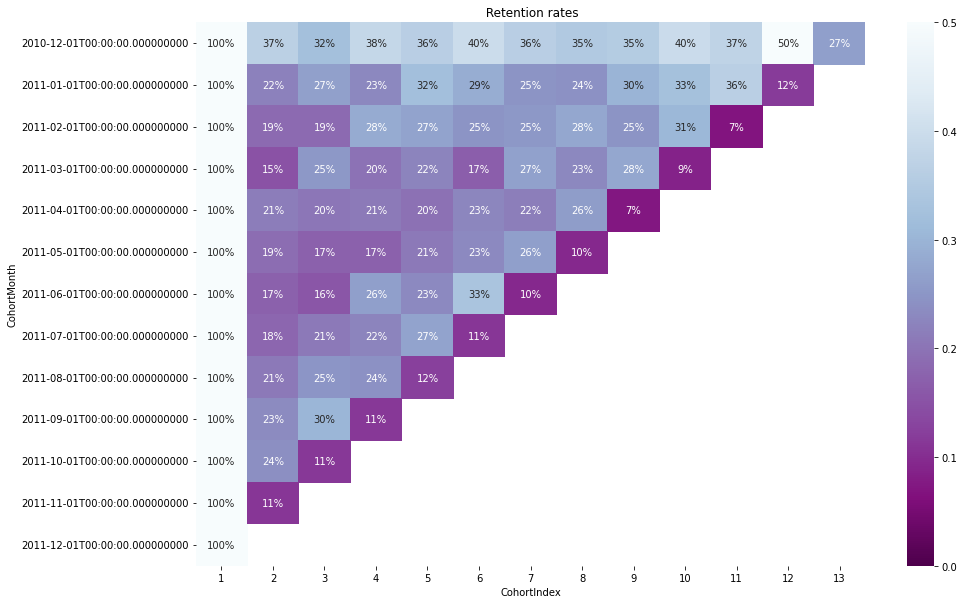

In [13]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

def get_month_int (dframe,column):
  year = dframe[column].dt.year
  month = dframe[column].dt.month
  day = dframe[column].dt.day
  return year, month, day

invoice_year,invoice_month,_ = get_month_int(df, 'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortIndex'] = year_diff * 12 + month_diff + 1

#count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

#return number of unique elements in the object
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

#retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size, axis=0) #axis=0 to ensure the divide along the row axis
retention.round(3) * 100 #to show the number as percentage

#build the heatmap
plt.figure(figsize=(15,10))
plt.title(' Retention rates')
sns.heatmap(data=retention, annot = True, fmt = '.0%', vmin = 0.0,vmax = 0.5, cmap="BuPu_r")
plt.show()

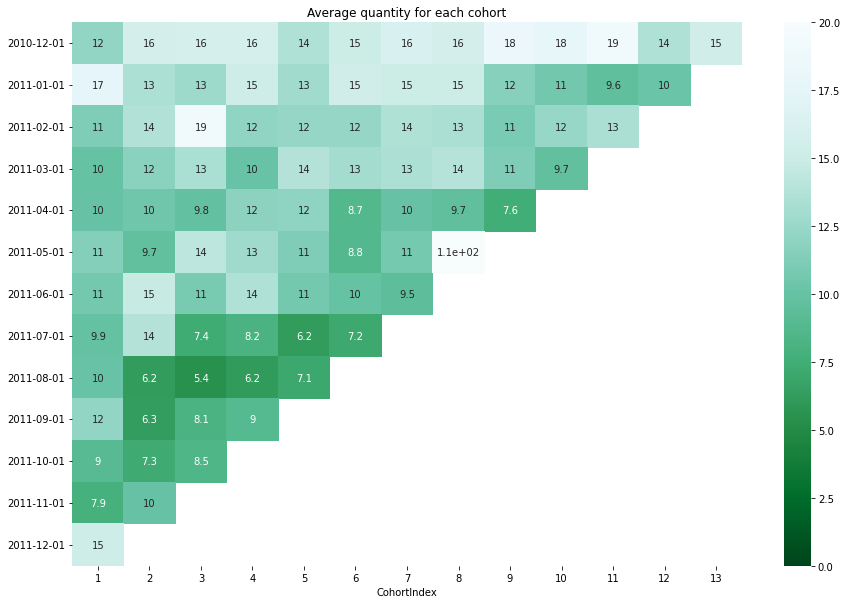

In [14]:
#average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 10))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity, annot = True, vmin = 0.0, vmax =20,cmap="BuGn_r")
plt.show()